In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np
import scipy.io as sio
import scipy.misc
import math
import pickle
from random import randint
import os
import os.path
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
def GCN(data_dir, ratio):
    ''' Perform image transformation Global Contraction Nornimlization 
    Args: 
        data_dir: the path to the SVHN, the data is in .mat format
        ratio: test and train ratio
    Return: 
        images after GCN transformation
    '''
    
    train_data = sio.loadmat(data_dir)
    x_train = train_data['X']
    y_train = train_data['y']
    y_train[y_train == 10] = 0
    x_train = x_train.transpose((3,0,1,2))
    x_train.astype(float)
    x_gray = np.dot(x_train, [[0.2989],[0.5870],[0.1140]])

    imsize = x_gray.shape[0]
    mean = np.mean(x_gray, axis=(1,2), dtype=float)
    std = np.std(x_gray, axis=(1,2), dtype=float, ddof=1)
    std[std < 1e-4] = 1
    x_GCN = np.zeros(x_gray.shape, dtype=float)
    for i in np.arange(imsize):
        x_GCN[i,:,:] = (x_gray[i,:,:] - mean[i]) / std[i]
    nums = x_GCN.shape[0]
    x_GCN = x_GCN.reshape((nums,-1))
    data = np.hstack((y_train,x_GCN))
    np.random.shuffle(data)
    cut=math.floor(nums*ratio)
    val,train = data[:cut,:], data[cut:,:]

    print("\n------- GCN done -------")
    return train, val

In [3]:
def read_SVHN(data_dir, ratio, batch_size):
    ''' read SCVN function images are 32 * 32 and in gray scale 
    Args: 
        data_dir: the path to the SVHN, the data is in .mat format
        ratio: test and train ratio
        batch_size: number of train images trained per time
    Return: 
        image_list: the first element of image_list is the train batch the second is the validation batch
        label_list: the first element of label_list is the train batch the second is the validation batch
    '''
    train,val = GCN(data_dir, ratio)
    img_width = 32
    img_height = 32
    img_depth = 1
    label_bytes = 1
    image_bytes = 1024
    record_bytes = 1025

    with tf.name_scope('input'):
        images_list = []
        label_batch_list = []
        for train_val in [train, val]:
            q = tf.train.input_producer(train_val)
            input_data = q.dequeue()

            label = tf.slice(input_data , [0], [1])
            label = tf.cast(label, tf.int32)

            image_raw = tf.slice(input_data , [1], [1024])
            image_raw = tf.reshape(image_raw, [1, 32, 32])
            image = tf.transpose(image_raw, (1,2,0))
            image = tf.cast(image, tf.float32)
            images, label_batch = tf.train.batch([image, label],
                                                batch_size = batch_size,
                                                num_threads = 16,
                                                capacity= 2000)

            n_classes = 10
            label_batch = tf.one_hot(label_batch, depth = n_classes)

            label_batch_list.append(tf.reshape(label_batch, [batch_size, n_classes]))
            images_list.append(images)


        return images_list, label_batch_list

In [4]:
def conv(layer_name, x, out_channels, kernel_size=[5,5], stride=[1,1,1,1]):
    '''Convolution op wrapper, use RELU activation after convolution
    Args:
        layer_name: e.g. conv1, pool1...
        x: input tensor, [batch_size, height, width, channels]
        out_channels: number of output channels (or comvolutional kernels)
        kernel_size: the size of convolutional kernel, VGG paper used: [3,3]
        stride: A list of ints. 1-D of length 4. VGG paper used: [1, 1, 1, 1]
        is_pretrain: if load pretrained parameters, freeze all conv layers.
        Depending on different situations, you can just set part of conv layers to be freezed.
        the parameters of freezed layers will not change when training.
    Returns:
        4D tensor
    '''

    in_channels = x.get_shape()[-1]
    with tf.variable_scope(layer_name):
        w = tf.get_variable(name='weights',
                            shape=[kernel_size[0], kernel_size[1], in_channels, out_channels],
                            initializer=tf.contrib.layers.xavier_initializer()) # default is uniform distribution initialization
        b = tf.get_variable(name='biases',
                            shape=[out_channels],
                            initializer=tf.constant_initializer(0.0))
        x = tf.nn.conv2d(x, w, stride, padding='SAME', name='conv')
        x = tf.nn.bias_add(x, b, name='bias_add')
        x = tf.nn.relu(x, name='relu')
        return x
    
def pool(layer_name, x, kernel=[1,2,2,1], stride=[1,2,2,1]):
    '''Pooling op
    Args:
        x: input tensor
        kernel: pooling kernel, VGG paper used [1,2,2,1], the size of kernel is 2X2
        stride: stride size, VGG paper used [1,2,2,1]
        padding:'SAME'
    '''
    with tf.variable_scope(layer_name):
        x = tf.nn.max_pool(x, kernel, strides=stride, padding='SAME', name=layer_name)
        return x

def FC_layer(layer_name, x, out_nodes):
    '''Wrapper for fully connected layers with RELU activation as default
    Args:
        layer_name: e.g. 'FC1', 'FC2'
        x: input feature map
        out_nodes: number of neurons for current FC layer
    '''
    shape = x.get_shape()
    size = shape[1].value * shape[2].value * shape[3].value

    with tf.variable_scope(layer_name):
        w = tf.get_variable('weights',
                            shape=[size, out_nodes],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('biases',
                            shape=[out_nodes],
                            initializer=tf.constant_initializer(0.0))
        flat_x = tf.reshape(x, [-1, size]) # flatten into 1D

        x = tf.nn.bias_add(tf.matmul(flat_x, w), b)
        x = tf.nn.relu(x)
        return x
    
def final_layer(layer_name, x, out_nodes):
    '''Wrapper for fully connected layers without activation function
    Args:
        layer_name: e.g. 'final_layer'
        x: input feature map
        out_nodes: number of neurons for current FC layer
    '''
    shape = x.get_shape()
    size = shape[-1].value
    with tf.variable_scope(layer_name):
        w = tf.get_variable('weights',
                            shape=[size, out_nodes],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('biases',
                            shape=[out_nodes],
                            initializer=tf.constant_initializer(0.0))
        flat_x = tf.reshape(x, [-1, size]) # flatten into 1D
        x = tf.nn.bias_add(tf.matmul(flat_x, w), b)
        return x

def drop_out(layer_name, x, keep_prob = 0.5):
    '''Wrapper for drop_out layer
    Args:
        layer_name: e.g. 'drop_out'
        x: input feature map
        kep_prob: the prob of a specific neuron is inactive for the next layer
    '''    
    with tf.variable_scope(layer_name):
        x = tf.nn.dropout(x, keep_prob)
        return x

def lossFn(logits, labels):
    '''Lost function
    Args: 
        logits: Logits tensor, float - [batch_size, NUM_CLASSES].
        labels: Labels tensor
    Returns: 
        loss tensor
    '''
    
    with tf.variable_scope('loss') as scope:
        labels = tf.cast(labels, tf.int64)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits\
                        (logits=logits, labels=labels, name='loss')
        loss = tf.reduce_mean(cross_entropy, name='loss')
        tf.summary.scalar(scope.name+'/loss', loss)
    return loss

def accuracyFn(logits, labels):
    """Evaluate the quality of the logits at predicting the label.
    Args:
        logits: Logits tensor, float - [batch_size, NUM_CLASSES].
        labels: Labels tensor
    Returns: 
        accuracy tensor
    """
    with tf.name_scope('accuracy') as scope:
      correct = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
      correct = tf.cast(correct, tf.float32)
      accuracy = tf.reduce_mean(correct)*100.0
      tf.summary.scalar(scope+'/accuracy', accuracy)
        
    return accuracy

def optimize(loss, learning_rate, global_step):
    '''optimization use AdamOptimizer
    Args: 
        loss: Loss tensor
        learning_rate: e10-4 is desired 
        global_step: non trainable varibal
    Returns: 
        train_op: train operation 
    '''
    with tf.name_scope('optimizer'):
        # optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss, global_step=global_step)
        return train_op

In [5]:
def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf
    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        shape = value.get_shape().as_list()
        dim = len(shape[1:-1])
        out = (tf.reshape(value, [-1] + shape[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, out],i)
        out_size = [-1] + [s * 2 for s in shape[1:-1]] + [shape[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

In [6]:
def display_features(v_name, pool_size, out_shape, p_v, figs, col_mp):
    
    w = [v for v in tf.trainable_variables() if v.name == v_name][0]
    
    #Reconstruction from the layer CNV-1
    featuresReLu = tf.placeholder(tf.float32, pool_size)
    unPool = unpool(featuresReLu)
    unReLu = tf.nn.relu(unPool)
    unBias  = unReLu
    unConv = tf.nn.conv2d_transpose(unBias, w, output_shape=out_shape , strides=[1,1,1,1], padding="SAME")
    
    plt.figure(figsize=figs)
    for i in range(figs[0]*figs[1]):
        isolated = p_v.copy()
        isolated[:,:,:,:i] = 0
        isolated[:,:,:,i+1:] = 0#These two lines set all other features other than feature i to 0
        totals = np.sum(isolated,axis=(1,2,3))
        best = np.argmax(totals,axis=0)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            pixelactive = sess.run(unConv, feed_dict={featuresReLu: isolated})
        #print(pixelactive.shape) 
        plt.subplot(figs[0],figs[1],i+1)    
        plt.imshow(pixelactive[best,:,:,0],cmap = col_mp)
        plt.axis('off') 
    plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.1, wspace=0.35)
    plt.show()

### Model Parameter Section 

In [7]:
N_CLASSES = 10
IMG_W =  32 # resize the image, if the input image is too large, training will be very slow.
IMG_H = 32
RATIO = 0.1 # take 20% of dataset as validation data
BATCH_SIZE = 64
TEST_BATCH_SIZE = 20
CAPACITY = 2000
MAX_STEP = 10000 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 # with current parameters, it is suggested to use learning rate<0.0001

data_dir = './data/SVHN/train_32x32.mat'
train_log_dir = './logs/SVHN/train'
val_log_dir = './logs/SVHN/val'

### Fit the Model

In [6]:
with tf.name_scope('input'):

    image_batch, label_batch  = read_SVHN(data_dir = data_dir,
                                                        ratio = 0.1,
                                                        batch_size = 64)
    tra_image_batch = image_batch[0]
    tra_label_batch = label_batch[0]

    val_image_batch = image_batch[1]
    val_label_batch = label_batch[1]


x = tf.placeholder(tf.float32, shape=[BATCH_SIZE, IMG_W, IMG_H, 1])
y_ = tf.placeholder(tf.int16, shape=[BATCH_SIZE,N_CLASSES])


c1 = conv('conv1', x, 16)
p1 = pool('pool1', c1)

c2 = conv('conv2', p1, 64)
p2 = pool('pool2', c2)

c3 = conv('conv3', p2, 128)
p3 = pool('pool3', c3)

fc = FC_layer('fc4', p3, out_nodes = 64)
do = drop_out('drop_out', fc, keep_prob = 0.5)
logits = final_layer('softmax', do, out_nodes=N_CLASSES)

loss = lossFn(logits, y_)
accuracy = accuracyFn(logits, y_)

my_global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = optimize(loss, learning_rate, my_global_step)
summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    tra_summary_writer = tf.summary.FileWriter(train_log_dir, sess.graph)
    val_summary_writer = tf.summary.FileWriter(val_log_dir, sess.graph)


    try:
        for step in np.arange(MAX_STEP):
            if coord.should_stop():
                break
            tra_images,tra_labels = sess.run([tra_image_batch, tra_label_batch])
            _, tra_loss, tra_acc = sess.run([train_op, loss, accuracy], feed_dict={x:tra_images, y_:tra_labels})
            
            if step % 5 == 0 or (step + 1) == MAX_STEP:

                print ('Step: %d, loss: %.4f, accuracy: %.4f%%' % (step, tra_loss, tra_acc))
                _, summary_str = sess.run([train_op, summary_op], feed_dict={x: tra_images, y_: tra_labels})
                tra_summary_writer.add_summary(summary_str, step)

            if step % 5 == 0 or (step + 1) == MAX_STEP:
                val_images, val_labels = sess.run([val_image_batch, val_label_batch])
                val_loss, val_acc = sess.run([loss, accuracy], feed_dict={x:val_images,y_:val_labels})

                print('**  Step %d, val loss = %.2f, val accuracy = %.2f%%  **' %(step, val_loss, val_acc))
                _, summary_str = sess.run([train_op, summary_op], feed_dict={x: val_images, y_: val_labels})
                val_summary_writer.add_summary(summary_str, step)
            
            if step == (MAX_STEP - 1):
                c1_v = sess.run(c1, feed_dict={x:tra_images})
                p1_v = sess.run(p1, feed_dict={c1:c1_v})
                c2_v = sess.run(c2, feed_dict={p1:p1_v})
                p2_v = sess.run(p2, feed_dict={c2:c2_v})
                c3_v = sess.run(c3, feed_dict={p2:p2_v})
                p3_v = sess.run(p3, feed_dict={c3:c3_v})

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')

    finally:
        coord.request_stop()
    coord.join(threads)


------- GCN done -------
Step: 0, loss: 2.3326, accuracy: 9.3750%
**  Step 0, val loss = 2.31, val accuracy = 14.06%  **
Step: 5, loss: 2.3141, accuracy: 12.5000%
**  Step 5, val loss = 2.30, val accuracy = 21.88%  **
Step: 10, loss: 2.2362, accuracy: 12.5000%
**  Step 10, val loss = 2.26, val accuracy = 12.50%  **
Step: 15, loss: 2.2694, accuracy: 17.1875%
**  Step 15, val loss = 2.26, val accuracy = 14.06%  **
Step: 20, loss: 2.2241, accuracy: 25.0000%
**  Step 20, val loss = 2.23, val accuracy = 23.44%  **
Step: 25, loss: 2.2572, accuracy: 21.8750%
**  Step 25, val loss = 2.25, val accuracy = 23.44%  **
Step: 30, loss: 2.2848, accuracy: 17.1875%
**  Step 30, val loss = 2.19, val accuracy = 17.19%  **
Step: 35, loss: 2.3277, accuracy: 10.9375%
**  Step 35, val loss = 2.22, val accuracy = 17.19%  **
Step: 40, loss: 2.2416, accuracy: 17.1875%
**  Step 40, val loss = 2.20, val accuracy = 17.19%  **
Step: 45, loss: 2.2144, accuracy: 20.3125%
**  Step 45, val loss = 2.16, val accuracy = 

### Performance

![image1](./fig/SVHN_uncov_train_acc.png)
![image2](./fig/SVHN_uncov_train_loss.png)
![image3](./fig/SVHN_uncov_val_acc.png)
![image4](./fig/SVHN_uncov_val_loss.png)

In [20]:
display_features(
                v_name = "conv1/weights:0", 
                pool_size = [None, 16,16,16],
                out_shape = [64,32,32,1],
                p_v = p1_v,
                figs = (4,4), 
                col_mp="gray")


NameError: name 'p1_v' is not defined

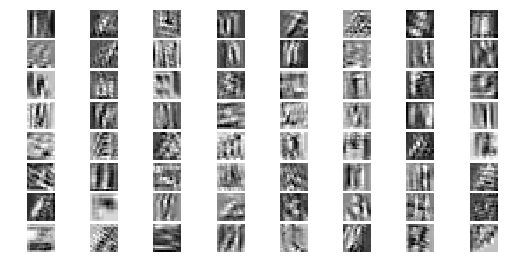

In [35]:
display_features(
                v_name = "conv2/weights:0", 
                pool_size = [None, 8, 8, 64],
                out_shape = [64,16,16,16],
                p_v = p2_v,
                figs = (8,8), 
                col_mp="gray")

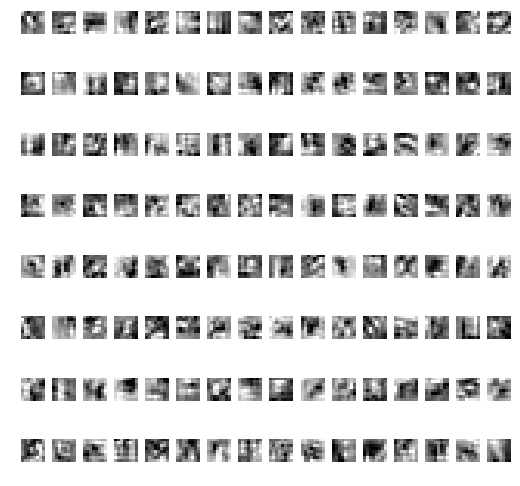

In [37]:
display_features(
                v_name = "conv3/weights:0", 
                pool_size = [None, 4, 4, 128],
                out_shape = [64,8,8,64],
                p_v = p3_v,
                figs = (8,16), 
                col_mp="gray")

## Uncov for CIFAR

In [8]:
def read_cifar10(data_dir, is_train, batch_size):
    """Read CIFAR10
    
    Args:
        data_dir: the directory of CIFAR10
        is_train: boolen
        batch_size:
        shuffle:       
    Returns:
        label: 1D tensor, tf.int32
        image: 4D tensor, [batch_size, height, width, 3], tf.float32
    
    """
    img_width = 32
    img_height = 32
    img_depth = 3
    label_bytes = 1
    image_bytes = img_width*img_height*img_depth
    
    
    with tf.name_scope('input'):
        
        if is_train:
            filenames = [os.path.join(data_dir, 'data_batch_%d.bin' %ii)
                                        for ii in np.arange(1, 6)]
        else:
            filenames = [os.path.join(data_dir, 'test_batch.bin')]
          
        filename_queue = tf.train.string_input_producer(filenames)
    
        reader = tf.FixedLengthRecordReader(label_bytes + image_bytes)
    
        key, value = reader.read(filename_queue)
           
        record_bytes = tf.decode_raw(value, tf.uint8)
        
        label = tf.slice(record_bytes, [0], [label_bytes])   
        label = tf.cast(label, tf.int32)
        
        image_raw = tf.slice(record_bytes, [label_bytes], [image_bytes])     
        image_raw = tf.reshape(image_raw, [img_depth, img_height, img_width])     
        image = tf.transpose(image_raw, (1,2,0)) # convert from D/H/W to H/W/D       
        image = tf.cast(image, tf.float32)

        image = tf.image.per_image_standardization(image) #substract off the mean and divide by the variance 



        images, label_batch = tf.train.shuffle_batch(
                                [image, label], 
                                batch_size = batch_size,
                                num_threads= 16,
                                capacity = 2000,
                                min_after_dequeue = 1500)

        
    
        n_classes = 10
        label_batch = tf.one_hot(label_batch, depth= n_classes)
        
        print("Read Data Done")
        return images, tf.reshape(label_batch, [batch_size, n_classes])

In [9]:
N_CLASSES = 10
IMG_W =  32 # resize the image, if the input image is too large, training will be very slow.
IMG_H = 32
RATIO = 0.1 # take 20% of dataset as validation data
BATCH_SIZE = 64
TEST_BATCH_SIZE = 20
CAPACITY = 2000
MAX_STEP = 10000 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 # with current parameters, it is suggested to use learning rate<0.0001

data_dir = './data/cifar-10-batches-bin'
train_log_dir = './logs/CIFAR/train/'
val_log_dir = './logs/CIFAR/val/'

In [10]:
with tf.name_scope('input'):

    tra_image_batch, tra_label_batch  = read_cifar10(data_dir = data_dir,
                                                     is_train = True,
                                                     batch_size = BATCH_SIZE)
    
    val_image_batch, val_label_batch  = read_cifar10(data_dir = data_dir,
                                                     is_train = False,
                                                     batch_size = BATCH_SIZE)


x = tf.placeholder(tf.float32, shape=[BATCH_SIZE, IMG_W, IMG_H, 3])
y_ = tf.placeholder(tf.int16, shape=[BATCH_SIZE,N_CLASSES])


c1 = conv('conv1', x, 32)
p1 = pool('pool1', c1)

c2 = conv('conv2', p1, 64)
p2 = pool('pool2', c2)


fc = FC_layer('fc3', p2, out_nodes = 64)
do = drop_out('drop_out', fc, keep_prob = 0.5)
logits = final_layer('softmax', do, out_nodes=N_CLASSES)

loss = lossFn(logits, y_)
accuracy = accuracyFn(logits, y_)

my_global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = optimize(loss, learning_rate, my_global_step)
summary_op = tf.summary.merge_all()


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    tra_summary_writer = tf.summary.FileWriter(train_log_dir, sess.graph)
    val_summary_writer = tf.summary.FileWriter(val_log_dir, sess.graph)


    try:
        for step in np.arange(MAX_STEP):
            if coord.should_stop():
                break
            tra_images,tra_labels = sess.run([tra_image_batch, tra_label_batch])
            _, tra_loss, tra_acc = sess.run([train_op, loss, accuracy], feed_dict={x:tra_images, y_:tra_labels})
            
            if step % 5 == 0 or (step + 1) == MAX_STEP:

                print ('Step: %d, loss: %.4f, accuracy: %.4f%%' % (step, tra_loss, tra_acc))
                _, summary_str = sess.run([train_op, summary_op], feed_dict={x: tra_images, y_: tra_labels})
                tra_summary_writer.add_summary(summary_str, step)

            if step % 5 == 0 or (step + 1) == MAX_STEP:
                val_images, val_labels = sess.run([val_image_batch, val_label_batch])
                val_loss, val_acc = sess.run([loss, accuracy], feed_dict={x:val_images,y_:val_labels})

                print('**  Step %d, val loss = %.2f, val accuracy = %.2f%%  **' %(step, val_loss, val_acc))
                _, summary_str = sess.run([train_op, summary_op], feed_dict={x: val_images, y_: val_labels})
                val_summary_writer.add_summary(summary_str, step)
            
            if step == (MAX_STEP - 1):
                c1_v = sess.run(c1, feed_dict={x:tra_images})
                p1_v = sess.run(p1, feed_dict={c1:c1_v})
                c2_v = sess.run(c2, feed_dict={p1:p1_v})
                p2_v = sess.run(p2, feed_dict={c2:c2_v})
                print ("Training Done")
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')

    finally:
        coord.request_stop()
    coord.join(threads)

Read Data Done
Read Data Done
Step: 0, loss: 2.3437, accuracy: 10.9375%
**  Step 0, val loss = 2.31, val accuracy = 21.88%  **
Step: 5, loss: 2.3226, accuracy: 15.6250%
**  Step 5, val loss = 2.29, val accuracy = 9.38%  **
Step: 9, loss: 2.3027, accuracy: 18.7500%
**  Step 9, val loss = 2.29, val accuracy = 10.94%  **


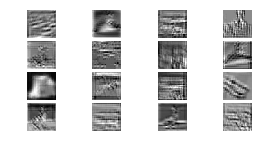

In [11]:
display_features(
                v_name = "conv1/weights:0", 
                pool_size = [None, 16,16,32],
                out_shape = [64,32,32,3],
                p_v = p1_v,
                figs = (4,4), 
                col_mp="gray")

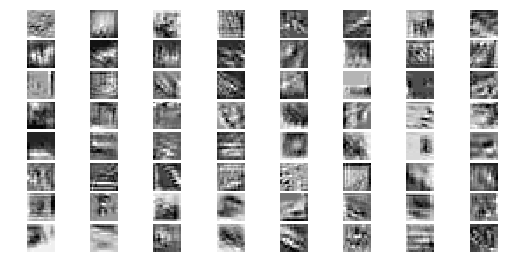

In [12]:
display_features(
                v_name = "conv2/weights:0", 
                pool_size = [None, 8, 8, 64],
                out_shape = [64,16,16,32],
                p_v = p2_v,
                figs = (8,8), 
                col_mp="gray")